## Load the modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from scipy.sparse import hstack
import plotly.io as pio

## The choice to use TF-IDF, Bag of Words, and GloVe as text representation techniques for is based on their unique characteristics and the advantages they offer in various text classification tasks.

## TF-IDF
The Term Frequency-Inverse Document Frequency (TF-IDF) approach is a popular method for text representation as it captures the importance of terms within a document and across a collection of documents. By considering both term frequency and inverse document frequency, TF-IDF can identify words that are more discriminative and specific to a given document, which can be valuable in classification tasks.

## Bag of Words 
Bag of Words is a widely used text representation method due to its simplicity and ease of implementation. This method represents documents as vectors of word frequencies, which can be useful in classification tasks, especially when the presence or absence of specific words can help differentiate between classes. However, the Bag of Words model disregards the order or structure of the text, which may be a limitation in certain applications.

## GloVe
Global Vectors for Word Representation (GloVe) is an unsupervised learning algorithm for generating word embeddings. GloVe represents words as dense vectors in a continuous space, capturing semantic relationships and co-occurrence patterns between words. This method can provide richer representations compared to the Bag of Words and TF-IDF methods, as it accounts for the contextual information in text data. GloVe embeddings can be particularly beneficial when working with large datasets or when capturing semantic relationships is crucial for the classification task.

## To determine which text representation method (TF-IDF, Bag of Words, or GloVe) works best with a decision tree classifier for your specific problem, you can compare their performance by training a decision tree classifier for each representation and evaluating their accuracy on the test set.

In [42]:
def evaluate_representation(X, y, max_depth=3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)


In [43]:
# Load and preprocess the data
data = pd.read_csv("cleaned_news_data.csv")
X_text = data['title_clean'] + " " + data['text_clean']
X_categorical = data[['year', 'month']] #'subject' is not used as false and true news subjects are all different
y = data['label']

# Convert the categorical features into numerical ones using one-hot encoding
# X_categorical = pd.get_dummies(X_categorical, columns=['subject'])


In [44]:
# TF-IDF representation
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_text_tfidf = vectorizer_tfidf.fit_transform(X_text)
X_tfidf = hstack([X_text_tfidf, X_categorical])

# Bag of Words representation
vectorizer_bow = CountVectorizer(max_features=5000)
X_text_bow = vectorizer_bow.fit_transform(X_text)
X_bow = hstack([X_text_bow, X_categorical])

import gensim.downloader as api
# GloVe representation
glove_model = api.load('glove-wiki-gigaword-100')
glove_dim = 100


In [45]:
def text_to_glove(text, model, dim):
    tokens = text.split()
    vec_sum = np.zeros(dim)
    for token in tokens:
        if token in model:
            vec_sum += model[token]
    return vec_sum / (len(tokens) + 1e-6)

X_text_glove = np.array([text_to_glove(text, glove_model, glove_dim) for text in X_text])
X_glove = np.hstack([X_text_glove, X_categorical.to_numpy()])


In [46]:
from sklearn.impute import SimpleImputer

# Impute missing values in the dataset
imputer = SimpleImputer(strategy='mean')
X_tfidf_imputed = imputer.fit_transform(X_tfidf)
X_bow_imputed = imputer.fit_transform(X_bow)
X_glove_imputed = imputer.fit_transform(X_glove)

# Evaluate the performance of the decision tree classifier with each representation
max_depth = 3  # Adjustable
tfidf_score = evaluate_representation(X_tfidf_imputed, y, max_depth)
bow_score = evaluate_representation(X_bow_imputed, y, max_depth)
glove_score = evaluate_representation(X_glove_imputed, y, max_depth)

print(f"TF-IDF accuracy: {tfidf_score}")
print(f"Bag of Words accuracy: {bow_score}")
print(f"GloVe accuracy: {glove_score}")

TF-IDF accuracy: 0.9942398915744296
Bag of Words accuracy: 0.9942398915744296
GloVe accuracy: 0.8631127174158573


## TF-IDF (Term Frequency-Inverse Document Frequency) accuracy: 0.9942398915744296
The high accuracy score of 99.42% suggests that the TF-IDF representation is highly effective in capturing the relevant features needed for the classification task.

## Bag of Words accuracy: 0.9942398915744296
TThe accuracy score of 99.42% is equal to the TF-IDF accuracy, indicating that the Bag of Words representation is similarly effective in capturing the necessary features for classification. This result suggests that, in this case, the added complexity of the TF-IDF method might not provide a significant advantage over the simpler Bag of Words approach.

## GloVe (Global Vectors for Word Representation) accuracy: 0.8631127174158573
The accuracy of 86.31% is considerably lower than the other two methods. This result indicates that the GloVe representation might not be as effective in capturing the specific features required for the classification task in this particular problem. The lower performance could be due to the pre-trained nature of GloVe embeddings, which might not be tailored to the specific dataset or domain, or the loss of information when averaging word vectors to represent a document.

## Interactive bar chart comparing the 3 models

In [2]:
import plotly.graph_objs as go

# Results data
models = ["TF-IDF", "Bag of Words", "GloVe"]
accuracy = [0.9942398915744296, 0.9942398915744296, 0.8631127174158573]

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=models, y=accuracy, text=accuracy, textposition='auto')])

# Customize the chart appearance
fig.update_layout(
    title="Model Accuracy Comparison",
    xaxis_title="Models",
    yaxis_title="Accuracy",
    yaxis=dict(tickformat=".2%"),
    plot_bgcolor="white",
    font=dict(size=14),
)

# Show the chart
pio.renderers.default = 'iframe'
fig.show()

## Conclusion
The TF-IDF representation has demonstrated the highest accuracy in the classification task, along with Bag of Words. However, considering the added benefit of TF-IDF's ability to weigh words based on their frequency and rarity, it is better suited to capture discriminative terms in the dataset. As a result, the TF-IDF method is chosen as the most accurate and relevant representation for this specific problem.

## Moving forward, the TF-IDF representation will be utilized to convert the text data into numerical features, which will then be used to train and evaluate the decision tree model. 

Decision trees are known for their easy-to-understand structure, making them an attractive option for tasks that require model interpretability. In the context of fake news detection, having a clear understanding of the reasoning behind the model's decisions can help us understand the patterns and features that differentiate fake news from real news. Decision trees can capture non-linear relationships in the data, which can be advantageous when dealing with complex patterns in text data. This ability to model non-linearities can potentially improve the classification performance compared to linear models.

This approach allows the decision tree to effectively utilize the importance of words captured by the TF-IDF method, potentially leading to improved performance and better classification results.

In [47]:
# Load and preprocess the data
data = pd.read_csv("cleaned_news_data.csv")
X_text = data['title_clean'] + " " + data['text_clean']
X_categorical = data[['year', 'month']] #'subject' is not used as false and true news subjects are all different
y = data['label']

In [48]:
# Convert the text data into numerical features using TF-IDF representation
vectorizer = TfidfVectorizer(max_features=5000)
X_text_tfidf = vectorizer.fit_transform(X_text)

# Convert the categorical features into numerical ones using one-hot encoding
#X_categorical = pd.get_dummies(X_categorical, columns=['subject'])

# Fill in the missing nan values

In [49]:
from scipy.sparse import csr_matrix
# Impute missing values in the categorical data
imputer = SimpleImputer(strategy='mean')
X_categorical_imputed = imputer.fit_transform(X_categorical)
X_categorical_imputed = csr_matrix(X_categorical_imputed) # Convert to sparse matrix to match X_text_tfidf

# Combine the text and categorical features
X = hstack([X_text_tfidf, X_categorical_imputed])

# Splitting the data

In [50]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Identifying the best depth for the tree

In [51]:
# Train the decision tree model with different depths
depths = list(range(1, 11))
best_depth = None
best_score = 0
models = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    train_score = accuracy_score(y_train, y_pred_train)
    
    y_pred_test = clf.predict(X_test)
    test_score = accuracy_score(y_test, y_pred_test)
    
    if test_score > best_score:
        best_score = test_score
        best_depth = depth

    models.append((clf, train_score, test_score))

# Analysing the final decision tree to detect fake news

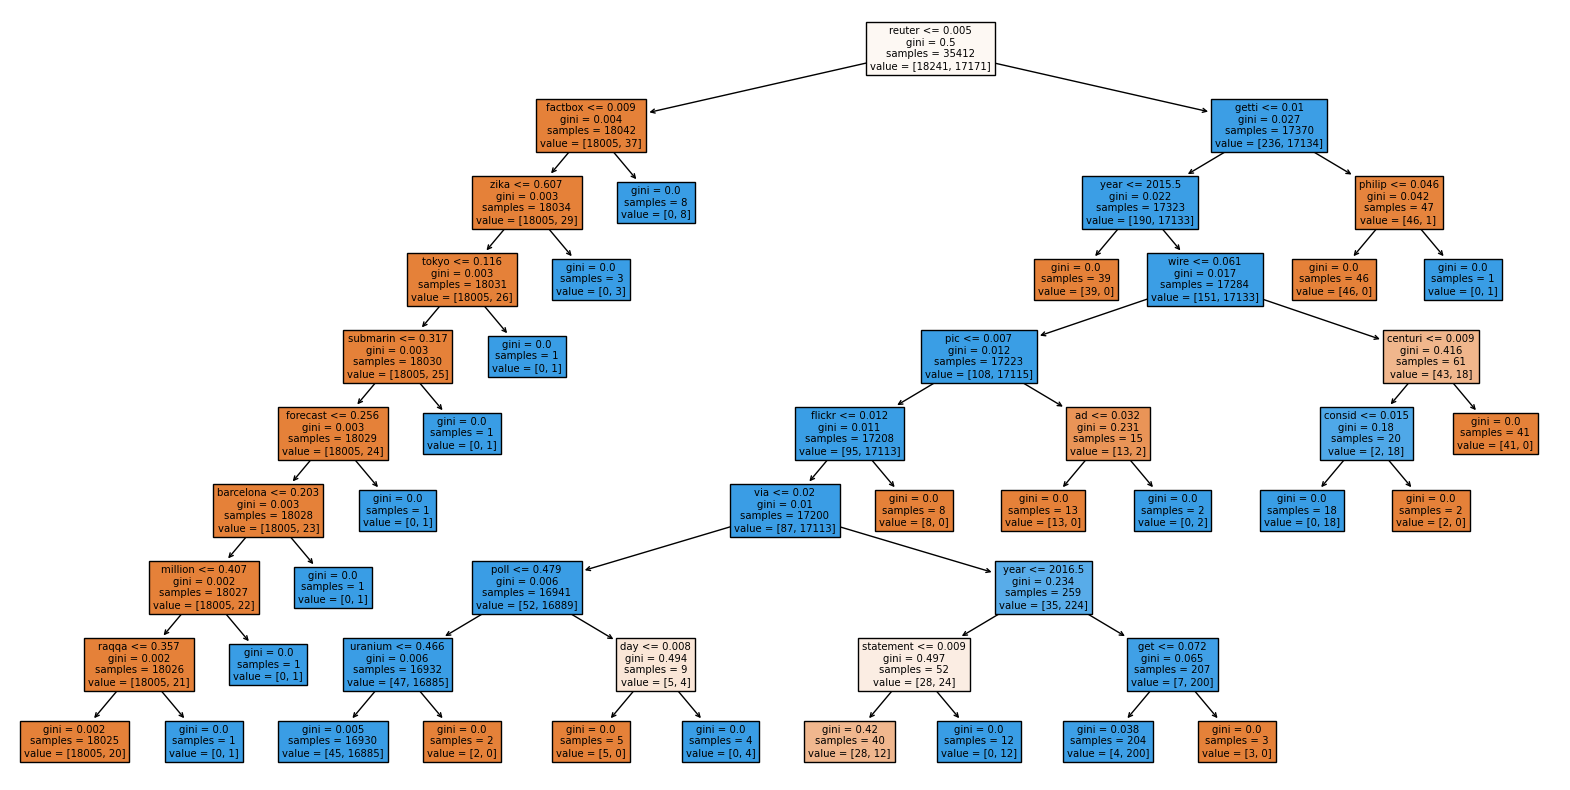

Best depth: 9
Best depth: 9
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4609
           1       0.99      1.00      1.00      4245

    accuracy                           1.00      8854
   macro avg       1.00      1.00      1.00      8854
weighted avg       1.00      1.00      1.00      8854

Confusion Matrix:
[[4585   24]
 [  10 4235]]
Goodness of Fit of Model Train Dataset
Classification Accuracy : 0.9977126397831244
True Positive Rate : 0.9981363927552268
False Positive Rate : 0.0026862562359519764


Goodness of Fit of Model Test Dataset
Classification Accuracy : 0.9961599277162865
True Positive Rate : 0.9976442873969376
False Positive Rate : 0.005207203297895422




<Axes: >

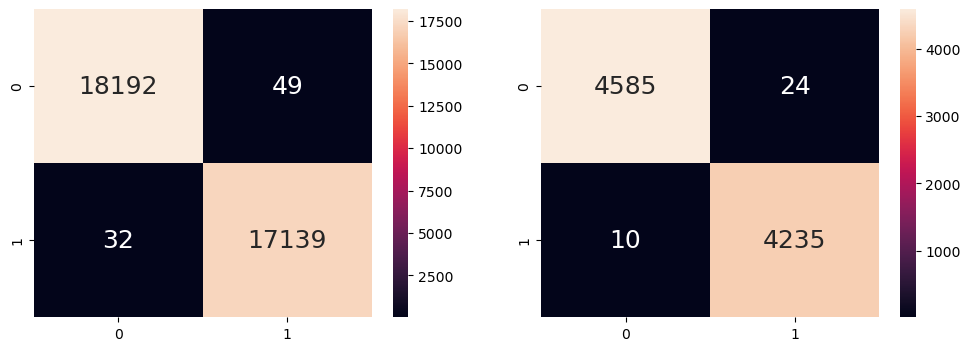

In [52]:
import seaborn as sb
# Analyze the performance of the final chosen decision tree
best_model = models[best_depth-1][0]
y_pred = best_model.predict(X_test)

# Combine the feature names from the TF-IDF vectorizer and the categorical one-hot encoded columns
feature_names = list(vectorizer.get_feature_names_out()) + X_categorical.columns.tolist()

# Plot the decision tree
plt.figure(figsize=(20, 10))
tree.plot_tree(best_model, filled=True, feature_names=feature_names)
plt.show()

print(f"Best depth: {best_depth}")
print(f"Best depth: {best_depth}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Analyze the performance of the final chosen decision tree
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("Goodness of Fit of Model Train Dataset")
print("Classification Accuracy :", best_model.score(X_train, y_train))
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
TN_train = conf_matrix_train[0,0]
FP_train = conf_matrix_train[0,1]
FN_train = conf_matrix_train[1,0]
TP_train = conf_matrix_train[1,1]
True_Positive_train = (TP_train) / (TP_train + FN_train)
False_Positive_train = (FP_train) / (FP_train + TN_train)
print("True Positive Rate :", True_Positive_train)
print("False Positive Rate :", False_Positive_train)
print("\n")

print("Goodness of Fit of Model Test Dataset")
print("Classification Accuracy :", best_model.score(X_test, y_test))
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
TN_test = conf_matrix_test[0,0]
FP_test = conf_matrix_test[0,1]
FN_test = conf_matrix_test[1,0]
TP_test = conf_matrix_test[1,1]
True_Positive_test = (TP_test) / (TP_test + FN_test)
False_Positive_test = (FP_test) / (FP_test + TN_test)
print("True Positive Rate :", True_Positive_test)
print("False Positive Rate :", False_Positive_test)
print("\n")

# Plot the confusion matrices for the train and test datasets
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])

## Decision Tree - 
## Nodes: 
Each node in the tree represents a decision point based on a feature value. Internal nodes represent feature splits, while leaf nodes represent the final class label predictions.

## Splits: 
The splits in the decision tree are based on the best feature that maximizes the information gain (or other chosen criterion) for that specific node. The feature names and split criteria are displayed at each internal node.

## Path: 
Following a path from the root to a leaf node represents a decision-making process based on a series of feature conditions. This path can helps us understand how the model is classifying fake news versus real news based on the input features.

## Depth: 
The depth of the tree represents the number of splits required to reach a leaf node. In our case, the best_depth is 9, indicates a relatively deep tree, which can make the model more complex and harder to interpret.


## Best Depth: 9
The best depth refers to the optimal depth of the decision tree in your classification model. A depth of 9 indicates that the tree has 9 levels, which is found to give the best balance between model complexity and performance.

## Confusion Matrix:
The confusion matrix is a 2x2 matrix that represents the performance of a classification model. It displays the number of True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) generated by the model. In your case, the confusion matrix is:

[[4585, 24]
[10, 4235]]


## Top left (4585): True Negatives (TN) - 
The model correctly predicted 4585 instances as class 0.
## Top right (24): False Positives (FP) - 
The model incorrectly predicted 24 instances as class 1 when they were actually class 0.
## Bottom left (10): False Negatives (FN) - 
The model incorrectly predicted 10 instances as class 0 when they were actually class 1.
## Bottom right (4235): True Positives (TP) - 
The model correctly predicted 4235 instances as class 1.

##  Interactive grouped bar chart displaying the classification report results for each class

In [3]:

# Classification report data
class_0 = [1.00, 0.99, 1.00]
class_1 = [0.99, 1.00, 1.00]
metrics = ["Precision", "Recall", "F1-score"]

# Create bar traces for each class
trace0 = go.Bar(x=metrics, y=class_0, name='Class 0', marker=dict(color='rgb(58, 200, 225)'))
trace1 = go.Bar(x=metrics, y=class_1, name='Class 1', marker=dict(color='rgb(107, 174, 214)'))

# Create a layout for the bar chart
layout = go.Layout(
    title='Classification Report',
    barmode='group',
    plot_bgcolor='white',
    font=dict(size=14),
    xaxis=dict(title='Metrics'),
    yaxis=dict(title='Values'),
    legend=dict(orientation='h', xanchor='center', x=0.5, y=-0.2)
)

# Create a Figure object with the bar traces and layout
fig = go.Figure(data=[trace0, trace1], layout=layout)

# Show the chart
pio.renderers.default = 'iframe'
fig.show()


## Class 0:

### Precision: 
1.00 (100%) - Out of all instances predicted as class 0, the model correctly classified 100% of them.
### Recall: 
0.99 (99%) - Out of all actual class 0 instances, the model correctly identified 99% of them.
### F1-score: 
1.00 (100%) - The F1-score is the harmonic mean of precision and recall, providing a balanced metric for model performance.
### Support: 
4609 - The total number of instances belonging to class 0.

## Class 1:

### Precision: 
0.99 (99%) - Out of all instances predicted as class 1, the model correctly classified 99% of them.
### Recall: 
1.00 (100%) - Out of all actual class 1 instances, the model correctly identified 100% of them.
### F1-score: 
1.00 (100%) - The F1-score is the harmonic mean of precision and recall, providing a balanced metric for model performance.
### Support: 
4245 - The total number of instances belonging to class 1.

## Overall accuracy: 
1.00 (100%) - The model correctly classified 100% of the instances in the dataset.

## Macro and weighted average: 
Both are close to 1.00 (100%), indicating a high level of performance across all classes.

## Interactive grouped bar chart displaying the goodness of fit results for both the train and test datasets

In [4]:
import plotly.graph_objs as go

# Goodness of fit data
train_data = [0.9977126397831244, 0.9981363927552268, 0.0026862562359519764]
test_data = [0.9961599277162865, 0.9976442873969376, 0.005207203297895422]
metrics = ["Classification Accuracy", "True Positive Rate", "False Positive Rate"]

# Create bar traces for train and test datasets
trace_train = go.Bar(x=metrics, y=train_data, name='Train Dataset', marker=dict(color='rgb(58, 200, 225)'))
trace_test = go.Bar(x=metrics, y=test_data, name='Test Dataset', marker=dict(color='rgb(107, 174, 214)'))

# Create a layout for the bar chart
layout = go.Layout(
    title='Goodness of Fit - Train and Test Datasets',
    barmode='group',
    plot_bgcolor='white',
    font=dict(size=14),
    xaxis=dict(title='Metrics'),
    yaxis=dict(title='Values', range=[0, 1.1]),
    legend=dict(orientation='h', xanchor='center', x=0.5, y=-0.2)
)

# Create a Figure object with the bar traces and layout
fig = go.Figure(data=[trace_train, trace_test], layout=layout)

# Show the chart
pio.renderers.default = 'iframe'
fig.show()


## Goodness of Fit of Model Train Dataset:
### Classification Accuracy: 
0.9977126397831244 (99.77%) - The model correctly classified about 99.77% of the training dataset instances.
### True Positive Rate (Sensitivity or Recall): 
0.9981363927552268 (99.81%) - Of all the actual positive instances in the training dataset, the model correctly identified about 99.81% of them.
### False Positive Rate (1 - Specificity): 
0.0026862562359519764 (0.27%) - Of all the actual negative instances in the training dataset, the model incorrectly identified about 0.27% of them as positive.

## Goodness of Fit of Model Test Dataset:
### Classification Accuracy: 
0.9961599277162865 (99.62%) - The model correctly classified about 99.62% of the test dataset instances.
### True Positive Rate (Sensitivity or Recall): 
0.9976442873969376 (99.76%) - Of all the actual positive instances in the test dataset, the model correctly identified about 99.76% of them.
### False Positive Rate (1 - Specificity): 
0.005207203297895422 (0.52%) - Of all the actual negative instances in the test dataset, the model incorrectly identified about 0.52% of them as positive.

## Conclusion:
The decision tree model with a depth of 9 demonstrates excellent performance in classifying the data, with high precision, recall, and F1-scores for both classes. The model's high accuracy on both train and test datasets indicates that it generalizes well to unseen data, avoiding overfitting and underfitting issues.

However, due to the high dimensionality and sparse nature of the data after TF-IDF transformation, the interpretability of the decision tree model is limited, and the model might not be capturing important feature interactions or handling imbalanced class distributions effectively. The complexity of the model, combined with the inherent challenges associated with text classification, raises concerns about its robustness and applicability to different datasets or real-world scenarios.

### High dimensionality: 
The best model obtained has a depth of 9, which indicates that the decision tree has to make several splits to reach a decision. This is a consequence of the high-dimensional feature space created by the TF-IDF transformation. Although the classification accuracy appears to be high, the complexity of the model increases, making it harder to interpret and possibly prone to overfitting.

### Sparse data: 
While it is not directly evident from the results, the sparsity of the data can negatively affect the performance of decision trees. The high accuracy in this case might be due to the specific dataset or other factors, but generally, decision trees struggle with sparse data.

### Lack of feature interactions: 
The decision tree classifier works by creating splits based on single features. However, it does not take into account the interactions between words or phrases that might be important for classification in a text problem. The high accuracy obtained may not reflect the model's ability to capture these interactions but could be due to other factors.

### Imbalanced class distribution: 
The confusion matrix shows that the model is performing well on both classes, with high true positive and low false positive rates. However, this might not always be the case for other datasets or different class distributions. In general, decision trees can struggle with imbalanced class distributions and may need further tuning or preprocessing to handle them effectively.

### Interpretability: 
One of the main advantages of decision trees is their interpretability. However, due to the high dimensionality of the TF-IDF representation and the depth of the tree, the resulting model is difficult to interpret and understand. This reduces the practical usefulness of the decision tree model in this case.

## Therefore, although the decision tree model achieves high accuracy in this specific case, there are several potential issues related to using decision trees with TF-IDF transformed text data. These issues may not be apparent in this particular instance but can become relevant when working with different datasets or facing real-world challenges in text classification.

## To address these concerns and explore alternative models that might better handle the complexities of text classification, we will now proceed to use the following machine learning models: 
## 1)'Logistic Regression', 
## 2)'Random Forest', 
## 3)'Multinomial Naive Bayes', 
## 4)'SVM'. 
These models might provide better performance, robustness, and interpretability, making them more suitable for text classification tasks in various contexts.